# CLIPDraw
Synthesize drawings to match a text prompt!


![](https://kvfrans.com/content/images/2021/06/Screen-Shot-2021-06-10-at-8.47.23-PM.png)


> This work presents CLIPDraw, an algorithm that synthesizes novel drawings based on natural language input. CLIPDraw does not require any training; rather a pre-trained CLIP language-image encoder is used as a metric for maximizing similarity between the given description and a generated drawing. Crucially, CLIPDraw operates over vector strokes rather than pixel images, a constraint that biases drawings towards simpler human-recognizable shapes. Results compare between CLIPDraw and other synthesis-through-optimization methods, as well as highlight various interesting behaviors of CLIPDraw, such as satisfying ambiguous text in multiple ways, reliably producing drawings in diverse artistic styles, and scaling from simple to complex visual representations as stroke count is increased. 





This Colab notebook goes along with the paper: [CLIPDraw: Exploring Text-to-Drawing Synthesis through Language-Image Encoders](https://arxiv.org/abs/2106.14843) 

by **Kevin Frans**, L.B. Soros, Olaf Witkowski

Read the blog post for cool results and analysis! [https://kvfrans.com/clipdraw-exploring-text-to-drawing-synthesis/](https://kvfrans.com/clipdraw-exploring-text-to-drawing-synthesis/)

Feel free to tweet me any cool creations, [@kvfrans](https://twitter.com/kvfrans)

Code adapted from diffvg: https://github.com/BachiLi/diffvg/blob/master/apps/painterly_rendering.py

--- 






**STEPS:**


1. Click "Connect" in the top right corner
2. Runtime -> Change runtime type -> Hardware accelerator -> GPU
2. Click the run button on "Pre Installation". This will install dependencies, it may take a while.
2. **Important:** Runtime -> Restart Runtime
3. Run the "Imports and Notebook Utilities" and "Load CLIP" sections.


5. "Curve Optimizer" will synthesize a drawing to match your text. You can edit the text prompt at the top of the code block.
6. "Video Renderer" can create videos that show the optimization process, and videos that render a drawing stroke-by-stroke.

In [ ]:
#@title Pre Installation {vertical-output: true}

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

# !pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
%cd /content/
!pip install svgwrite
!pip install svgpathtools
!pip install cssutils
!pip install numba
!pip install torch-tools
!pip install visdom

!git clone https://github.com/BachiLi/diffvg
%cd diffvg
# !ls
!git submodule update --init --recursive

data = []
with open("/content/diffvg/CMakeLists.txt", "r+") as inFile:
    for line in inFile:
        if "find_package(TensorFlow)" in line:
            pass
        else:
            data.append(line)
    inFile.seek(0)
    for d in data:
        inFile.write(d)
    inFile.truncate()
!python setup.py install

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git --no-deps

CUDA version: 11.8
/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 5.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 14.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.2 MB/s eta 0:00:

In [ ]:
#@title Imports and Notebook Utilities {vertical-output: true}
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img = img.resize((max_size, max_size))
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))


def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

from torchvision import utils
def show_img(img):
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    img = np.uint8(img * 254)
    # img = np.repeat(img, 4, axis=0)
    # img = np.repeat(img, 4, axis=1)
    pimg = PIL.Image.fromarray(img, mode="RGB")
    imshow(pimg)

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

import numpy as np
import torch
import os

# torch.set_default_tensor_type('torch.cuda.FloatTensor')

print("Torch version:", torch.__version__)

# !pip install DALL-E

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU 0: Tesla T4 (UUID: GPU-97d4ee8b-dbfd-e03f-7715-abe9a18df326)
Torch version: 2.0.1+cu118


In [ ]:
#@title Load CLIP {vertical-output: true}

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import os
import clip
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

# Load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load('ViT-B/32', device, jit=False)

nouns = "aardvark abyssinian accelerator accordion account accountant acknowledgment acoustic acrylic act action active activity actor actress adapter addition address adjustment adult advantage advertisement advice afghanistan africa aftermath afternoon aftershave afterthought age agenda agreement air airbus airmail airplane airport airship alarm albatross alcohol algebra algeria alibi alley alligator alloy almanac alphabet alto aluminium aluminum ambulance america amount amusement anatomy anethesiologist anger angle angora animal anime ankle answer ant antarctica anteater antelope anthony anthropology apartment apology apparatus apparel appeal appendix apple appliance approval april aquarius arch archaeology archeology archer architecture area argentina argument aries arithmetic arm armadillo armchair armenian army arrow art ash ashtray asia asparagus asphalt asterisk astronomy athlete atm atom attack attempt attention attic attraction august aunt australia australian author authorisation authority authorization avenue babies baboon baby back backbone bacon badge badger bag bagel bagpipe bail bait baker bakery balance balinese ball balloon bamboo banana band bandana bangladesh bangle banjo bank bankbook banker bar barbara barber barge baritone barometer base baseball basement basin basket basketball bass bassoon bat bath bathroom bathtub battery battle bay beach bead beam bean bear beard beast beat beautician beauty beaver bed bedroom bee beech beef beer beet beetle beggar beginner begonia behavior belgian belief believe bell belt bench bengal beret berry bestseller betty bibliography bicycle bike bill billboard biology biplane birch bird birth birthday bit bite black bladder blade blanket blinker blizzard block blood blouse blow blowgun blue board boat bobcat body bolt bomb bomber bone bongo bonsai book bookcase booklet boot border botany bottle bottom boundary bow bowl bowling box boy bra brace bracket brain brake branch brand brandy brass brazil bread break breakfast breath brian brick bridge british broccoli brochure broker bronze brother brother-in-law brow brown brush bubble bucket budget buffer buffet bugle building bulb bull bulldozer bumper bun burglar burma burn burst bus bush business butane butcher butter button buzzard cabbage cabinet cable cactus cafe cake calculator calculus calendar calf call camel camera camp can canada canadian cancer candle cannon canoe canvas cap capital cappelletti capricorn captain caption car caravan carbon card cardboard cardigan care carnation carol carp carpenter carriage carrot cart cartoon case cast castanet cat catamaran caterpillar cathedral catsup cattle cauliflower cause caution cave c-clamp cd ceiling celery celeste cell cellar cello celsius cement cemetery cent centimeter century ceramic cereal certification chain chair chalk chance change channel character chard charles chauffeur check cheek cheese cheetah chef chemistry cheque cherries cherry chess chest chick chicken chicory chief child children chill chime chimpanzee chin china chinese chive chocolate chord christmas christopher chronometer church cicada cinema circle circulation cirrus citizenship city clam clarinet class claus clave clef clerk click client climb clipper cloakroom clock close closet cloth cloud cloudy clover club clutch coach coal coast coat cobweb cockroach cocktail cocoa cod coffee coil coin coke cold collar college collision colombia colon colony color colt column columnist comb comfort comic comma command commission committee community company comparison competition competitor composer composition computer condition condor cone confirmation conga congo conifer connection consonant continent control cook cooking copper copy copyright cord cork cormorant corn cornet correspondent cost cotton couch cougar cough country course court cousin cover cow cowbell crab crack cracker craftsman crate crawdad crayfish crayon cream creator creature credit creditor creek crib cricket crime criminal crocodile crocus croissant crook crop cross crow crowd crown crush cry cub cuban cucumber cultivator cup cupboard cupcake curler currency current curtain curve cushion custard customer cut cuticle cycle cyclone cylinder cymbal dad daffodil dahlia daisy damage dance dancer danger daniel dash dashboard database date daughter david day dead deadline deal death deborah debt debtor decade december decimal decision decrease dedication deer defense deficit degree delete delivery den denim dentist deodorant department deposit description desert design desire desk dessert destruction detail detective development dew diamond diaphragm dibble dictionary dietician difference digestion digger digital dill dime dimple dinghy dinner dinosaur diploma dipstick direction dirt disadvantage discovery discussion disease disgust dish distance distribution distributor diving division divorced dock doctor dog dogsled doll dollar dolphin domain donald donkey donna door dorothy double doubt downtown dragon dragonfly drain drake drama draw drawbridge drawer dream dredger dress dresser dressing drill drink drive driver driving drizzle drop drug drum dry dryer duck duckling dugout dungeon dust eagle ear earth earthquake ease east edge edger editor editorial education edward eel effect egg eggnog eggplant egypt eight elbow element elephant elizabeth ellipse emery employee employer encyclopedia end enemy energy engine engineer engineering english enquiry entrance environment epoch epoxy equinox equipment era error estimate ethernet ethiopia euphonium europe evening event examination example exchange exclamation exhaust ex-husband existence expansion experience expert explanation ex-wife eye eyebrow eyelash eyeliner face facilities fact factory fahrenheit fairies fall family fan fang farm farmer fat father father-in-law faucet fear feast feather feature february fedelini feedback feeling feet felony female fender ferry ferryboat fertilizer fiber fiberglass fibre fiction field fifth fight fighter file find fine finger fir fire fired fireman fireplace firewall fish fisherman flag flame flare flat flavor flax flesh flight flock flood floor flower flugelhorn flute fly foam fog fold font food foot football footnote force forecast forehead forest forgery fork form format fortnight foundation fountain fowl fox foxglove fragrance frame france freckle freeze freezer freighter french freon friction friday fridge friend frog front frost frown fruit fuel fur furniture galley gallon game gander garage garden garlic gas gasoline gate gateway gauge gazelle gear gearshift geese gemini gender geography geology geometry george geranium german germany ghana ghost giant giraffe girdle girl gladiolus glass glider gliding glockenspiel glove glue goal goat gold goldfish golf gondola gong good-bye goose gore-tex gorilla gosling government governor grade grain gram granddaughter grandfather grandmother grandson grape graphic grass grasshopper gray grease great-grandfather great-grandmother greece greek green grenade grey grill grip ground group grouse growth guarantee guatemalan guide guilty guitar gum gun gym gymnast hacksaw hail hair haircut half-brother half-sister halibut hall hallway hamburger hammer hamster hand handball handicap handle handsaw harbor hardboard hardcover hardhat hardware harmonica harmony harp hat hate hawk head headlight headline health hearing heart heat heaven hedge height helen helicopter helium hell helmet help hemp hen heron herring hexagon hill himalayan hip hippopotamus history hobbies hockey hoe hole holiday home honey hood hook hope horn horse hose hospital hot hour hourglass house hovercraft hub hubcap humidity humor hurricane hyacinth hydrant hydrofoil hydrogen hyena hygienic ice icebreaker icicle icon idea ikebana illegal imprisonment improvement impulse inch income increase index india indonesia industry ink innocent input insect instruction instrument insulation insurance interactive interest internet interviewer intestine invention inventory invoice iran iraq iris iron island israel italian italy jacket jaguar jail jam james january japan japanese jar jasmine jason jaw jeans jeep jeff jelly jellyfish jennifer jet jewel jogging john join joke joseph journey judge judo juice july jumbo jump jumper june jury justice jute kale kamikaze kangaroo karate karen kayak kendo kenneth kenya ketchup kettle kettledrum kevin key keyboard keyboarding kick kidney kilogram kilometer kimberly kiss kitchen kite kitten kitty knee knickers knife knight knot knowledge kohlrabi korean laborer lace ladybug lake lamb lamp lan land landmine language larch lasagna latency latex lathe laugh laundry laura law lawyer layer lead leaf learning leather leek leg legal lemonade lentil leo leopard letter lettuce level libra library license lier lift light lightning lilac lily limit linda line linen link lion lip lipstick liquid liquor lisa list literature litter liver lizard llama loaf loan lobster lock locket locust look loss lotion love low lumber lunch lunchroom lung lunge lute luttuce lycra lynx lyocell lyre lyric macaroni machine macrame magazine magic magician maid mail mailbox mailman makeup malaysia male mall mallet man manager mandolin manicure manx map maple maraca marble march margaret margin maria marimba mark mark market married mary mascara mask mass match math mattock may mayonnaise meal measure meat mechanic medicine meeting melody memory men menu mercury message metal meteorology meter methane mexican mexico mice michael michelle microwave middle mile milk milkshake millennium millimeter millisecond mimosa mind mine minibus mini-skirt minister mint minute mirror missile mist mistake mitten moat modem mole mom monday money monkey month moon morning morocco mosque mosquito mother mother-in-law motion motorboat motorcycle mountain mouse moustache mouth move multi-hop multimedia muscle museum music musician mustard myanmar nail name nancy napkin narcissus nation neck need needle neon nepal nephew nerve nest net network news newsprint newsstand nic nickel niece nigeria night nitrogen node noise noodle north north america north korea norwegian nose note notebook notify novel november number numeric nurse nut nylon oak oatmeal objective oboe observation occupation ocean ocelot octagon octave october octopus odometer offence offer office oil okra olive onion open opera operation ophthalmologist opinion option orange orchestra orchid order organ organisation organization ornament ostrich otter ounce output outrigger oval oven overcoat owl owner ox oxygen oyster package packet page pail pain paint pair pajama pakistan palm pamphlet pan pancake pancreas panda pansy panther panties pantry pants panty pantyhose paper paperback parade parallelogram parcel parent parentheses park parrot parsnip part particle partner partridge party passbook passenger passive pasta paste pastor pastry patch path patient patio patricia paul payment pea peace peak peanut pear pedestrian pediatrician peen peer-to-peer pelican pen penalty pencil pendulum pentagon peony pepper perch perfume period periodical peripheral permission persian person peru pest pet pharmacist pheasant philippines philosophy phone physician piano piccolo pickle picture pie pig pigeon pike pillow pilot pimple pin pine ping pink pint pipe pisces pizza place plain plane planet plant plantation plaster plasterboard plastic plate platinum play playground playroom pleasure plier plot plough plow plywood pocket poet point poison poland police policeman polish politician pollution polo polyester pond popcorn poppy population porch porcupine port porter position possibility postage postbox pot potato poultry pound powder power precipitation preface prepared pressure price priest print printer prison probation process processing produce product production professor profit promotion propane property prose prosecution protest protocol pruner psychiatrist psychology ptarmigan puffin pull puma pump pumpkin punch punishment puppy purchase purple purpose push pvc pyjama pyramid quail quality quart quarter quartz queen question quicksand quiet quill quilt quince quit quiver quotation rabbi rabbit racing radar radiator radio radish raft rail railway rain rainbow raincoat rainstorm rake ramie random range rat rate raven ravioli ray rayon reaction reading reason receipt recess record recorder rectangle red reduction refrigerator refund regret reindeer relation relative religion relish reminder repair replace report representative request resolution respect responsibility rest restaurant result retailer revolve revolver reward rhinoceros rhythm rice richard riddle rifle ring rise risk river riverbed road roadway roast robert robin rock rocket rod roll romania romanian ronald roof room rooster root rose rotate route router rowboat rub rubber rugby rule run russia russian rutabaga ruth sack sagittarius sail sailboat sailor salad salary sale salesman salmon salt sampan samurai sand sandra sandwich santa sarah sardine satin saturday sauce saudi arabia sausage save saw saxophone scale scallion scanner scarecrow scarf scene scent schedule school science scissors scooter scorpio scorpion scraper screen screw screwdriver sea seagull seal seaplane search seashore season seat second secretary secure security seed seeder segment select selection self semicircle semicolon sense sentence separated september servant server session sex shade shadow shake shallot shame shampoo shape share shark sharon shears sheep sheet shelf shell shield shingle ship shirt shock shoe shoemaker shop shorts shoulder shovel show shrimp shrine siamese siberian side sideboard sidecar sidewalk sign signature silica silk silver sing singer single sink sister sister-in-law size skate skiing skill skin skirt sky slash slave sled sleep sleet slice slime slip slipper slope smash smell smile smoke snail snake sneeze snow snowboarding snowflake snowman snowplow snowstorm soap soccer society sociology sock soda sofa softball softdrink software soil soldier son song soprano sort sound soup sousaphone south africa south america south korea soy soybean space spade spaghetti spain spandex spark sparrow spear specialist speedboat sphere sphynx spider spike spinach spleen sponge spoon spot spring sprout spruce spy square squash squid squirrel stage staircase stamp star start starter state statement station statistic steam steel stem step step-aunt step-brother stepdaughter step-daughter step-father step-grandfather step-grandmother stepmother step-mother step-sister stepson step-son step-uncle steven stew stick stinger stitch stock stocking stomach stone stool stop stopsign stopwatch store storm story stove stranger straw stream street streetcar stretch string structure study sturgeon submarine substance subway success sudan suede sugar suggestion suit summer sun sunday sundial sunflower sunshine supermarket supply support surfboard surgeon surname surprise susan sushi swallow swamp swan sweater sweatshirt sweatshop swedish sweets swim swimming swing swiss switch sword swordfish sycamore syria syrup system table tablecloth tabletop tachometer tadpole tail tailor taiwan talk tank tanker tanzania target taste taurus tax taxi taxicab tea teacher teaching team technician teeth television teller temper temperature temple tempo tendency tennis tenor tent territory test text textbook texture thailand theater theory thermometer thing thistle thomas thought thread thrill throat throne thumb thunder thunderstorm thursday ticket tie tiger tights tile timbale time timer timpani tin tip tire titanium title toad toast toe toenail toilet tomato tom-tom ton tongue tooth toothbrush toothpaste top tornado tortellini tortoise touch tower town toy tractor trade traffic trail train tramp transaction transmission transport trapezoid tray treatment tree trial triangle trick trigonometry trip trombone trouble trousers trout trowel truck trumpet trunk t-shirt tsunami tub tuba tuesday tugboat tulip tuna tune turkey turkey turkish turn turnip turnover turret turtle tv twig twilight twine twist typhoon tyvek uganda ukraine ukrainian umbrella uncle underclothes underpants undershirt underwear unit united kingdom unshielded use utensil uzbekistan vacation vacuum valley value van vase vault vegetable vegetarian veil vein velvet venezuela venezuelan verdict vermicelli verse vessel vest veterinarian vibraphone vietnam view vinyl viola violet violin virgo viscose vise vision visitor voice volcano volleyball voyage vulture waiter waitress walk wall wallaby wallet walrus war warm wash washer wasp waste watch watchmaker water waterfall wave wax way wealth weapon weasel weather wedge wednesday weed weeder week weight whale wheel whip whiskey whistle white wholesaler whorl wilderness william willow wind windchime window windscreen windshield wine wing winter wire wish witch withdrawal witness wolf woman women wood wool woolen word work workshop worm wound wrecker wren wrench wrinkle wrist writer xylophone yacht yak yam yard yarn year yellow yew yogurt yoke yugoslavian zebra zephyr zinc zipper zone zoo zoology"
nouns = nouns.split(" ")
noun_prompts = ["a drawing of a " + x for x in nouns]

# Calculate features
with torch.no_grad():
    nouns_features = model.encode_text(torch.cat([clip.tokenize(noun_prompts).to(device)]))
print(nouns_features.shape, nouns_features.dtype)


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.6MiB/s]


torch.Size([2343, 512]) torch.float16


In [ ]:
#preprocess.transforms = preprocess.transforms[:2] + [preprocess.transforms[-1]]
#preprocess

In [ ]:
#@title Helper functions
def check_colinear(v, w): # check whether or not two vectors are colinear, useful to force a parallelogram
    return torch.abs((torch.norm(v) * torch.norm(w)) - torch.dot(v,w)) < 1e-12

def vectors_angle_cos(v,w): #computes the cosinus of the angle between vectors v and w
  return torch.dot(v,w)/(torch.norm(v) * torch.norm(w))

In [ ]:

#from google.colab import drive
#drive.mount('/content/drive')
def create_polygon_from_center_and_orientation(center, angle, width, factor):
  """
    Creates, using a center and an angle, a polygon representing a square with that center and rotated by that angle

    center: a tensor, the center of the square
    angle: a tensor(float), the angle by which the square is turned
    width: int, the width of the canvas
    factor: float, the length of one diagonal of the square
  """
  factor = factor
  rotationMatrix = torch.zeros(2,2)
  rotationMatrix[0][0] = torch.cos(angle)
  rotationMatrix[0][1] = -torch.sin(angle)
  rotationMatrix[1][0] = torch.sin(angle)
  rotationMatrix[1][1] = torch.cos(angle)
  
  p1 = center  + (torch.tensor([-1,-1]) * factor) @ rotationMatrix
  p2 = center + (torch.tensor([1,-1])  * factor) @ rotationMatrix
  p3 = center + (torch.tensor([1,1])  * factor) @ rotationMatrix
  p4 = center + (torch.tensor([-1,1])   * factor) @ rotationMatrix
  #print(p4)
  points = torch.cat([p1, p2, p3, p4], dim = 0) * width
  #points.requires_grad = True
  #print(points.requires_grad)
  return pydiffvg.Polygon(points = points, is_closed = True)

In [ ]:
def centers_penalization(centers, threshold_distance):
  """
  center1: tensor corresponding to a given center
  other_centers: tensor containing all centers except center1
  threshold_distance: float over which the distance is not penalized, under which it is

  Penalizes the distance between centers to avoid overlapping of squares. It is done as:
  1) If the distance between two centers is big, it is not taken into account into penalization
  2) Otherwise it is, like some kind of reverse ReLU
  """
  final = 0
  for center1 in centers:
    other_centers = torch.stack(centers[:i] + centers[i+1:])
    distances = torch.norm(center1 - other_centers, dim = 2) 
    distances_2 = F.relu(threshold_distance - distances) #This way, if a distance > threshold, then thershold - distance < 0 and relu will discard it, while still being able to compute grad
    distances_3 = torch.pow(distances_2, 2)
    final += distances_3.sum()
  return final

In [ ]:
def penalizing_empty_space(centers):
  """ 
  applies the penalization of empty space, i.e the L = max(min(|| ci - cj||**2)), as per the TA's suggestion
  will also try the L = min(max(|| ci - cj||**2))
  
  """
  distances = torch.zeros(len(centers))
  
  for i in range(len(centers)):
    
    center = centers[i]
    tmp = torch.stack(centers[:i] + centers[i+1:]) #all centers except the current iteration
    tmp = torch.norm(center - tmp, dim = 2)
    
    min_distance = tmp.min()
    distances[i] = min_distance
  return distances.max()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pydiffvg
import torch
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
import torchvision
import torchvision.transforms as transforms


/content/diffvg/apps


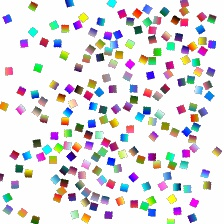

render loss: 86.4375
iteration: 10

Top predictions:

    distribution: 7.03%
        particle: 6.81%
      processing: 2.84%
     interactive: 2.39%
            node: 1.83%
           limit: 1.62%
        division: 1.62%
         network: 1.13%
      arithmetic: 0.95%
        boundary: 0.91%


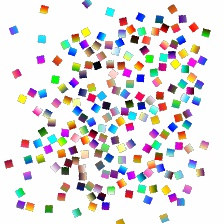

render loss: 76.125
iteration: 20

Top predictions:

        particle: 4.68%
     interactive: 1.98%
           limit: 1.89%
    distribution: 1.72%
      processing: 1.26%
          helium: 1.17%
         numeric: 1.09%
          effect: 1.01%
          bubble: 0.91%
          amount: 0.88%


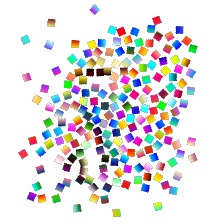

render loss: 68.3125
iteration: 30

Top predictions:

        particle: 2.40%
          bubble: 1.79%
      processing: 1.73%
    distribution: 1.55%
            bead: 1.21%
     interactive: 1.12%
          effect: 0.94%
           limit: 0.63%
      population: 0.63%
          cereal: 0.57%


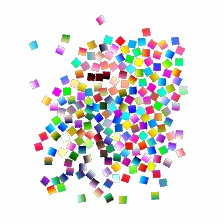

render loss: 63.28125
iteration: 40

Top predictions:

          sneeze: 2.24%
          bubble: 2.10%
             gum: 1.72%
         popcorn: 1.72%
         drizzle: 1.16%
        particle: 1.02%
           sleet: 0.98%
     exclamation: 0.98%
           shake: 0.86%
            bead: 0.85%


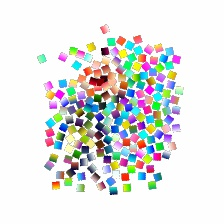

render loss: 61.9375
iteration: 50

Top predictions:

            loss: 1.23%
           sleet: 1.21%
             gum: 1.09%
            move: 0.87%
            bead: 0.83%
           error: 0.78%
           shake: 0.76%
          steven: 0.68%
          effect: 0.67%
           smash: 0.67%


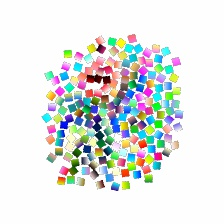

render loss: 60.6875
iteration: 60

Top predictions:

             gum: 3.34%
     exclamation: 3.13%
           spike: 1.21%
         popcorn: 1.15%
           thumb: 1.10%
           shake: 1.03%
          freeze: 0.91%
       polyester: 0.82%
          cancer: 0.77%
            loss: 0.77%


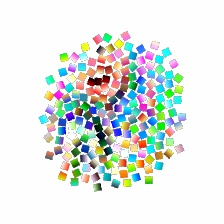

render loss: 60.21875
iteration: 70

Top predictions:

             gum: 2.16%
          freeze: 2.03%
         disease: 1.35%
         freezer: 1.21%
          cancer: 1.21%
          sneeze: 1.02%
          health: 0.96%
     exclamation: 0.81%
           error: 0.69%
            file: 0.60%


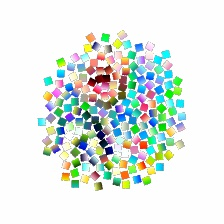

render loss: 59.875
iteration: 80

Top predictions:

             gum: 2.91%
         freezer: 2.00%
          freeze: 1.51%
          button: 1.02%
         digital: 0.90%
            soda: 0.89%
          sneeze: 0.88%
          energy: 0.86%
            salt: 0.82%
          effect: 0.81%


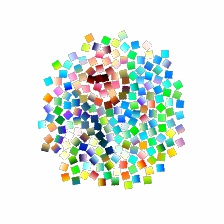

render loss: 59.84375
iteration: 90

Top predictions:

             gum: 2.53%
         popcorn: 2.24%
          sneeze: 1.64%
          cereal: 1.59%
          freeze: 1.24%
           shake: 1.14%
           sleet: 1.12%
          bubble: 1.11%
            bead: 1.09%
           spike: 1.06%


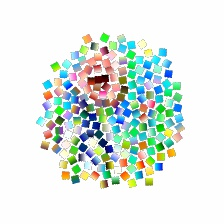

render loss: 59.21875
iteration: 100

Top predictions:

             gum: 3.20%
          freeze: 2.49%
         plastic: 2.06%
         freezer: 1.85%
           spike: 0.99%
            bead: 0.97%
          sneeze: 0.89%
          cancer: 0.85%
     exclamation: 0.83%
           anger: 0.67%


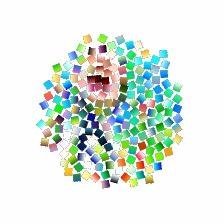

render loss: 59.40625
iteration: 110

Top predictions:

          freeze: 2.72%
             gum: 2.29%
         freezer: 1.76%
          cancer: 1.73%
             soy: 1.70%
             ice: 1.44%
            bead: 1.12%
           enemy: 1.00%
        nitrogen: 0.99%
           grape: 0.93%


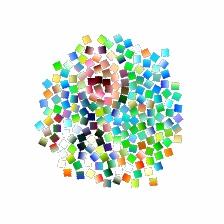

render loss: 59.46875
iteration: 120

Top predictions:

          freeze: 4.18%
         freezer: 2.04%
         plastic: 1.47%
           anger: 1.26%
             gum: 1.22%
          cancer: 1.04%
           giant: 1.02%
             ice: 0.99%
     exclamation: 0.80%
           shock: 0.79%


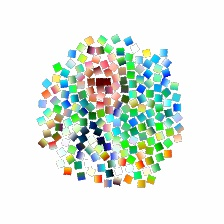

render loss: 59.25
iteration: 130

Top predictions:

             gum: 2.48%
          freeze: 2.13%
         freezer: 1.90%
           anger: 1.44%
          sneeze: 1.42%
           shock: 1.19%
             ice: 1.07%
           teeth: 0.99%
            cell: 0.94%
           enemy: 0.94%


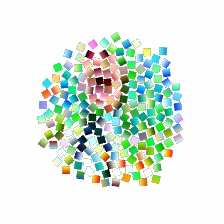

render loss: 59.125
iteration: 140

Top predictions:

          freeze: 2.79%
     exclamation: 2.51%
          sneeze: 1.57%
           spike: 1.09%
             gum: 0.92%
           thumb: 0.84%
         plastic: 0.76%
           sleet: 0.74%
             soy: 0.73%
             ice: 0.68%


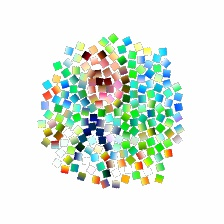

render loss: 59.125
iteration: 150

Top predictions:

          sneeze: 2.16%
           shock: 1.49%
          attack: 1.09%
           burst: 1.07%
           anger: 1.04%
             nut: 1.04%
             gum: 0.96%
           enemy: 0.89%
          energy: 0.87%
        reaction: 0.78%


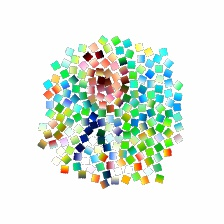

render loss: 59.03125
iteration: 160

Top predictions:

          sneeze: 3.67%
          freeze: 2.29%
             gum: 1.87%
         plastic: 1.31%
            cell: 1.17%
          energy: 0.96%
           shock: 0.84%
          cancer: 0.84%
         freezer: 0.79%
          cereal: 0.73%


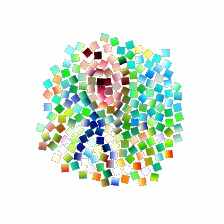

render loss: 58.875
iteration: 170

Top predictions:

          freeze: 5.62%
           spike: 2.53%
             gum: 1.85%
         freezer: 1.61%
            file: 1.14%
             ice: 1.02%
         diamond: 0.89%
           anger: 0.76%
          steven: 0.75%
           thumb: 0.70%


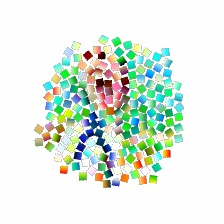

render loss: 58.96875
iteration: 180

Top predictions:

             gum: 7.51%
          freeze: 3.08%
         freezer: 2.76%
            bead: 2.55%
         plastic: 1.50%
          steven: 1.41%
           spike: 1.35%
           teeth: 1.33%
             ice: 1.12%
            bolt: 0.98%


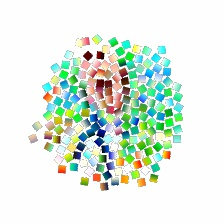

render loss: 59.125
iteration: 190

Top predictions:

          sneeze: 2.17%
         popcorn: 1.86%
          freeze: 1.83%
             gum: 1.45%
         freezer: 1.38%
     exclamation: 1.09%
          sponge: 1.07%
           shock: 0.98%
          cereal: 0.86%
         dentist: 0.75%


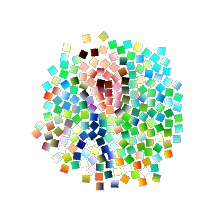

render loss: 59.15625
iteration: 200

Top predictions:

          freeze: 2.38%
          sneeze: 1.94%
           anger: 1.14%
           spike: 1.14%
          cancer: 0.98%
             gum: 0.88%
         plastic: 0.81%
             ice: 0.79%
           kevin: 0.76%
           thumb: 0.70%


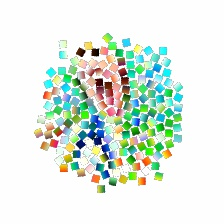

render loss: 59.28125
iteration: 210

Top predictions:

             gum: 4.19%
           spike: 3.11%
         freezer: 2.31%
          freeze: 2.28%
          sneeze: 2.04%
           anger: 1.43%
           teeth: 1.18%
         dentist: 1.15%
            bead: 1.08%
         jogging: 0.86%


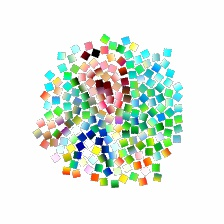

render loss: 58.8125
iteration: 220

Top predictions:

           spike: 5.31%
          sneeze: 3.43%
          freeze: 3.38%
         freezer: 2.11%
           anger: 1.95%
             gum: 1.84%
           teeth: 1.32%
          cancer: 1.30%
             dew: 1.22%
           shock: 1.19%


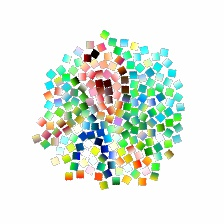

render loss: 58.78125
iteration: 230

Top predictions:

          freeze: 8.43%
          sneeze: 4.73%
         freezer: 2.45%
             gum: 2.17%
           spike: 1.97%
           anger: 1.82%
           teeth: 1.42%
            soda: 1.33%
          cancer: 1.25%
          cereal: 1.20%


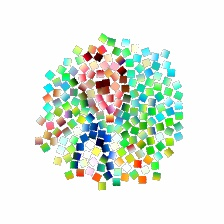

render loss: 59.21875
iteration: 240

Top predictions:

           teeth: 3.79%
          sneeze: 3.20%
          freeze: 2.16%
             gum: 2.13%
           anger: 1.94%
         freezer: 1.88%
           mouth: 1.56%
           shock: 1.42%
            cell: 1.37%
           tooth: 1.31%


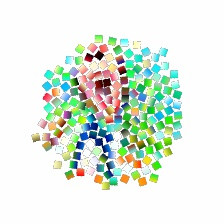

render loss: 58.875
iteration: 250

Top predictions:

             gum: 6.38%
          freeze: 2.83%
           spike: 2.58%
         dentist: 2.54%
         popcorn: 1.72%
          sneeze: 1.72%
           teeth: 1.64%
         freezer: 1.59%
       polyester: 1.38%
            bead: 1.34%


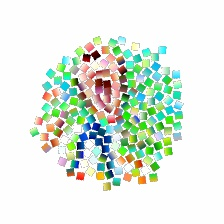

render loss: 58.8125
iteration: 260

Top predictions:

          sneeze: 4.39%
             gum: 3.42%
          cereal: 2.62%
            bead: 2.39%
         popcorn: 1.89%
         freezer: 1.77%
         dentist: 1.69%
           anger: 1.06%
           teeth: 1.04%
            soda: 1.00%


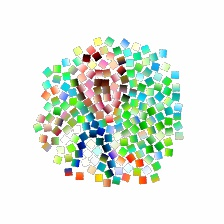

render loss: 58.78125
iteration: 270

Top predictions:

           teeth: 4.66%
             gum: 3.63%
           tooth: 3.15%
          sneeze: 2.31%
         freezer: 1.80%
         dentist: 1.74%
          freeze: 1.56%
           mouth: 1.49%
             ice: 1.20%
            cell: 1.16%


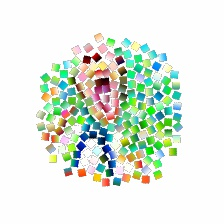

render loss: 58.84375
iteration: 280

Top predictions:

             gum: 4.95%
          freeze: 2.16%
            bead: 1.68%
           grape: 1.58%
          sneeze: 1.51%
         freezer: 1.46%
             pea: 1.27%
          steven: 1.19%
             nut: 1.07%
             ice: 1.05%


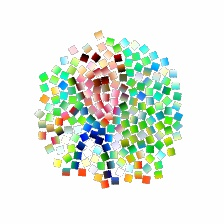

render loss: 58.8125
iteration: 290

Top predictions:

          freeze: 3.35%
          steven: 2.53%
         freezer: 2.53%
           spike: 2.34%
             gum: 2.16%
            bolt: 2.13%
          sneeze: 1.76%
            bead: 1.61%
           shock: 1.37%
         shallot: 1.16%


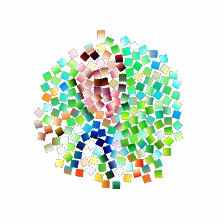

render loss: 58.90625
iteration: 300

Top predictions:

          freeze: 2.52%
             gum: 2.16%
          sneeze: 1.55%
           spike: 1.50%
         jogging: 1.48%
         freezer: 1.37%
         dentist: 1.14%
           hedge: 1.05%
           anger: 0.93%
            corn: 0.83%


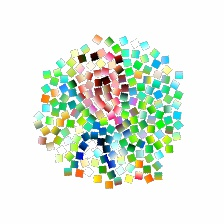

render loss: 59.28125
iteration: 310

Top predictions:

          freeze: 4.77%
          sneeze: 3.49%
             gum: 2.72%
         freezer: 1.37%
           spike: 1.05%
           anger: 1.03%
          cancer: 0.98%
            loss: 0.84%
           shock: 0.83%
             ice: 0.80%


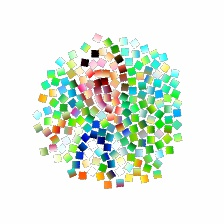

render loss: 59.53125
iteration: 320

Top predictions:

          sneeze: 4.59%
          freeze: 3.57%
           anger: 3.15%
             gum: 2.66%
           teeth: 2.27%
           spike: 1.94%
         dentist: 1.61%
           mouth: 1.31%
           shock: 1.29%
         freezer: 1.23%


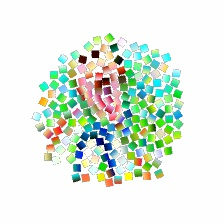

render loss: 59.09375
iteration: 330

Top predictions:

         dentist: 3.34%
          freeze: 2.49%
             gum: 2.09%
          sneeze: 2.06%
           teeth: 1.68%
           anger: 1.21%
         freezer: 1.12%
           tooth: 0.99%
          temper: 0.83%
             ice: 0.82%


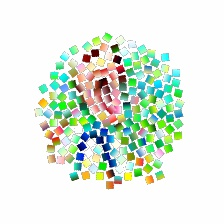

render loss: 58.90625
iteration: 340

Top predictions:

          freeze: 3.26%
         freezer: 2.62%
          sneeze: 1.91%
             gum: 1.64%
          energy: 1.54%
            bead: 1.26%
           shock: 1.14%
           spike: 1.14%
         popcorn: 1.07%
          cereal: 1.04%


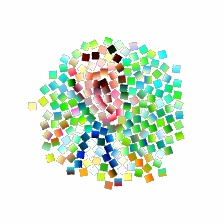

render loss: 59.0
iteration: 350

Top predictions:

             gum: 3.14%
           teeth: 3.09%
         popcorn: 3.00%
          sneeze: 2.52%
            corn: 2.09%
          cereal: 1.65%
           tooth: 1.27%
         dentist: 1.15%
            bead: 1.14%
           spike: 1.08%


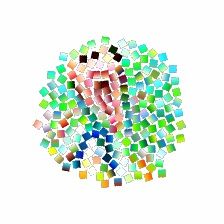

render loss: 59.0
iteration: 360

Top predictions:

          sneeze: 11.11%
          throat: 2.48%
           mouth: 2.22%
           teeth: 2.06%
          tongue: 1.96%
           anger: 1.93%
         dentist: 1.70%
          freeze: 1.50%
             gum: 1.39%
         hearing: 1.23%


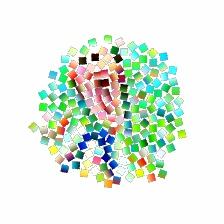

render loss: 58.78125
iteration: 370

Top predictions:

          sneeze: 5.58%
             gum: 4.49%
          freeze: 3.39%
         freezer: 2.12%
            bead: 2.09%
     exclamation: 2.02%
           spike: 1.99%
           anger: 1.55%
         popcorn: 1.50%
           shock: 1.21%


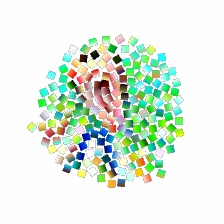

render loss: 58.6875
iteration: 380

Top predictions:

          sneeze: 18.46%
             gum: 2.83%
           cough: 2.01%
           anger: 1.72%
         dentist: 1.38%
           mouth: 1.28%
           shock: 1.24%
           teeth: 1.01%
            sing: 0.96%
          throat: 0.96%


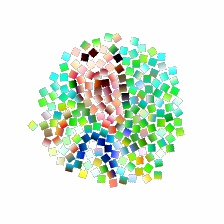

render loss: 58.65625
iteration: 390

Top predictions:

          sneeze: 6.53%
             gum: 3.23%
          freeze: 2.81%
         dentist: 2.29%
           teeth: 2.12%
           anger: 1.93%
           spike: 1.53%
           mouth: 1.21%
             nut: 1.17%
          tongue: 1.17%


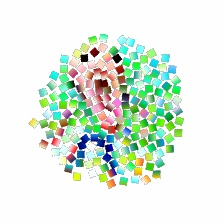

render loss: 59.1875
iteration: 400

Top predictions:

          sneeze: 7.35%
             gum: 6.00%
          freeze: 2.39%
         freezer: 1.36%
           anger: 1.34%
           shock: 1.01%
       polyester: 0.98%
         disease: 0.98%
        reaction: 0.88%
             ice: 0.77%


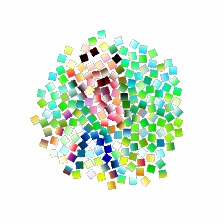

render loss: 59.625
iteration: 410

Top predictions:

             gum: 4.47%
           teeth: 4.27%
          sneeze: 2.89%
      toothpaste: 1.92%
           tooth: 1.81%
         jogging: 1.52%
         dentist: 1.47%
            soda: 1.30%
           mouth: 1.28%
           spike: 1.26%


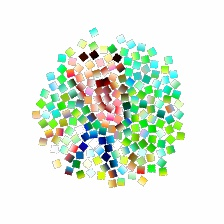

render loss: 58.96875
iteration: 420

Top predictions:

          freeze: 3.47%
            bead: 2.01%
          sneeze: 1.86%
             gum: 1.24%
             run: 1.06%
            push: 1.04%
         shallot: 1.04%
           shock: 0.98%
           spike: 0.90%
            kick: 0.86%


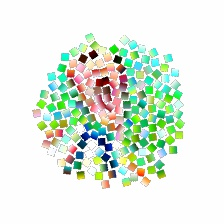

render loss: 58.84375
iteration: 430

Top predictions:

             gum: 3.96%
           teeth: 3.78%
         dentist: 3.04%
           tooth: 1.57%
          sneeze: 1.53%
           anger: 1.46%
          freeze: 1.37%
           grape: 1.31%
          cancer: 1.08%
           spike: 1.02%


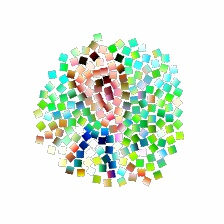

render loss: 59.0
iteration: 440

Top predictions:

          sneeze: 2.77%
             gum: 2.56%
           spike: 2.26%
             ice: 1.68%
          freeze: 1.48%
           anger: 1.14%
            bead: 1.04%
           shock: 1.02%
            soda: 0.90%
             dew: 0.86%


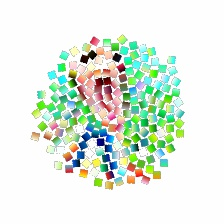

render loss: 58.9375
iteration: 450

Top predictions:

          sneeze: 2.94%
             gum: 2.94%
          freeze: 2.05%
           smash: 1.90%
         freezer: 1.87%
           spike: 1.84%
         dentist: 1.75%
           teeth: 1.62%
            bead: 1.17%
           anger: 1.00%


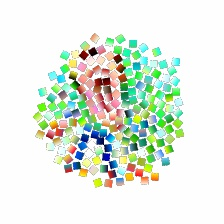

render loss: 59.09375
iteration: 460

Top predictions:

          sneeze: 6.70%
             gum: 4.19%
           spike: 2.35%
           teeth: 1.83%
          freeze: 1.59%
         freezer: 1.59%
           anger: 1.38%
          cereal: 1.20%
           shock: 1.20%
            bead: 1.18%


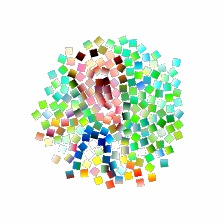

render loss: 59.21875
iteration: 470

Top predictions:

          sneeze: 8.01%
             gum: 4.09%
          freeze: 4.03%
           spike: 2.26%
           teeth: 2.22%
           anger: 1.96%
         freezer: 1.96%
         dentist: 1.51%
     exclamation: 1.35%
           shock: 1.23%


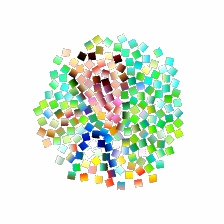

render loss: 59.125
iteration: 480

Top predictions:

          sneeze: 5.70%
          freeze: 3.80%
           teeth: 2.87%
             gum: 2.61%
         freezer: 2.45%
           spike: 1.27%
           tooth: 1.25%
             ice: 1.12%
         dentist: 1.11%
            soda: 1.11%


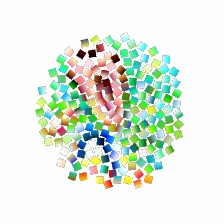

render loss: 58.875
iteration: 490

Top predictions:

          sneeze: 5.87%
           teeth: 2.86%
          throat: 1.74%
           mouth: 1.66%
           tooth: 1.63%
           shock: 1.44%
           anger: 1.37%
          freeze: 1.27%
          tongue: 1.27%
         freezer: 1.23%


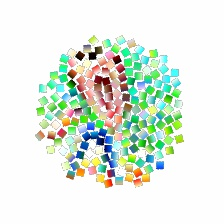

render loss: 58.84375
iteration: 500

Top predictions:

          freeze: 4.65%
          sneeze: 2.82%
             gum: 1.97%
           spike: 1.91%
             ice: 1.42%
           anger: 1.40%
         freezer: 1.25%
           shock: 1.23%
          cancer: 1.12%
            salt: 0.87%


In [ ]:
#@title Curve Optimizer {vertical-output: true}
%cd /content/diffvg/apps/
prompt = "Screaming man"
neg_prompt = "grey white blue"
neg_prompt_2 = "Many small bad drawings"
text_input = clip.tokenize(prompt).to(device)
text_input_neg1 = clip.tokenize(neg_prompt).to(device)
text_input_neg2 = clip.tokenize(neg_prompt_2).to(device)
use_negative = True # Use negative prompts?

# Thanks to Katherine Crowson for this. 
# In the CLIPDraw code used to generate examples, we don't normalize images
# before passing into CLIP, but really you should. Turn this to True to do that.
use_normalized_clip = True 

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_input)
    text_features_neg1 = model.encode_text(text_input_neg1)
    text_features_neg2 = model.encode_text(text_input_neg2)

pydiffvg.set_print_timing(False)

gamma = 1.0

# ARGUMENTS. Feel free to play around with these, especially num_paths.
args = lambda: None
args.num_polygons = 200
factor = 1/60# to have squares of size (2*factor, 2*factor)  
threshold_distance = 2 * math.sqrt(2)*factor #diameter of a square
args.num_iter = 500
#args.max_width = 50

# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())
device = torch.device('cuda')
pydiffvg.set_device(device)

canvas_width, canvas_height = 224, 224
num_paths = args.num_polygons
#max_width = args.max_width

# Image Augmentation Transformation
augment_trans = transforms.Compose([
    #transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
    transforms.RandomResizedCrop(canvas_width, scale=(0.7,0.9)),
])

if use_normalized_clip:
    augment_trans = transforms.Compose([
    transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
    transforms.RandomResizedCrop(canvas_width, scale=(0.7,0.9)),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])


# Initialize Random Curves
shapes = []
shape_groups = []
points_to_optimize = []
angles_to_optimize = []
color_vars = []
stop_colors_list = []
begin_points_list=[]
end_points_list=[]
filling = set()
max_filling_size = math.floor(num_paths/3)
for i in range(num_paths):
  if len(filling) < max_filling_size:
    filling.add(i)
  center = torch.tensor([(random.random(), random.random())])
  center.requires_grad = True

  angle = torch.tensor([random.random() * math.pi/2])
  angle.requires_grad = True

  color = pydiffvg.LinearGradient(\
    begin = torch.tensor([50.0, 50.0]),
    end = torch.tensor([200.0, 200.0]),
    offsets = torch.tensor([0.0, 1.0]),
    stop_colors = torch.tensor([[0.2, 0.5, 0.7, 1.0],
                                [0.7, 0.2, 0.5, 1.0]]))

  begin_n = torch.tensor([random.random(), random.random()], requires_grad=True)
  end_n = torch.tensor([random.random(), random.random()], requires_grad=True)
  stop_colors = torch.tensor([[random.random(), random.random(), random.random(), random.random()],
                            [random.random(), random.random(), random.random(), random.random()]], requires_grad=True)

  fill_color = color

  begin_points_list.append(begin_n)
  end_points_list.append(end_n)

  points_to_optimize.append(center)
  angles_to_optimize.append(angle)
  color_vars.append(fill_color)


  shapes.append(create_polygon_from_center_and_orientation(center, angle, canvas_width,factor))
  polygon_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),  fill_color = fill_color)
  shape_groups.append(polygon_group)
  #color_parameters.append(begin_n)
  #color_parameters.append(end_n)
  stop_colors_list.append(stop_colors)

# Just some diffvg setup
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
render = pydiffvg.RenderFunction.apply
img = render(canvas_width, canvas_height, 2, 2, 0, None, *scene_args)


# Optimizers
points_optim = torch.optim.Adam(points_to_optimize, lr=.01)
#width_optim = torch.optim.Adam(stroke_width_vars, lr=0.1)
color_optim = torch.optim.Adam(stop_colors_list, lr=0.1)
angle_optim = torch.optim.Adam(angles_to_optimize, lr = 0.1)


losses = []
# Run the main optimization loop
for t in range(1,args.num_iter+1):

    
    
    points_optim.zero_grad()
    
    color_optim.zero_grad()
    angle_optim.zero_grad()
    
    


    for k in range(len(stop_colors_list)):
      temp_poly = create_polygon_from_center_and_orientation(points_to_optimize[k], angles_to_optimize[k], canvas_width,factor)
      color_vars[k].stop_colors= stop_colors_list[k]
      color_vars[k].begin = temp_poly.points[0] 
      color_vars[k].end = temp_poly.points[1] 
      




    shapes = []
    shape_groups = []
    for i in range(len(points_to_optimize)):
      shapes.append(create_polygon_from_center_and_orientation(points_to_optimize[i], angles_to_optimize[i], canvas_width,factor))
      shape_groups.append(pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),  fill_color = color_vars[i]))

    scene_args = pydiffvg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, canvas_height, 2, 2, t, None, *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    if t % 5 == 0:
        pydiffvg.imwrite(img.cpu(), '/content/res/iter_{}.png'.format(int(t/5)), gamma=gamma)
    img = img[:, :, :3]
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW

    loss = 0
    NUM_AUGS = 4
    img_augs = []
    for n in range(NUM_AUGS):
        img_augs.append(augment_trans(img))
    im_batch = torch.cat(img_augs)
    image_features = model.encode_image(im_batch)
    for n in range(NUM_AUGS):
        loss -= 5 * torch.cosine_similarity(text_features, image_features[n:n+1], dim=1)
        if use_negative:
            loss += torch.cosine_similarity(text_features_neg1, image_features[n:n+1], dim=1) * 0.3
            loss += torch.cosine_similarity(text_features_neg2, image_features[n:n+1], dim=1) * 0.3

    

    grid_penalty = 0
    v = torch.tensor([0.5,0.5])

    
    distance_penalty = (1/threshold_distance) * centers_penalization(points_to_optimize, threshold_distance)
    empty_space_penalty = 0.5 * penalizing_empty_space(points_to_optimize)
    for i, center in enumerate(points_to_optimize):
      grid_penalty += 0.5* torch.norm(center-v)**2
    
    #distance_penalty /= len(points_to_optimize)
    #grid_penalty /= len(points_to_optimize)
    #print("Grid penalty: ", grid_penalty)
    #print("Distance penalty: ", distance_penalty)
    #print("Empty space penalty: ", empty_space_penalty)
    #print("----------------------------------------------------------")
    #print(distance_penalty)
    loss +=5*distance_penalty
    loss += 3*grid_penalty
    loss += empty_space_penalty 
    #print(empty_space_penalty)
    losses.append(loss.item())
    # Backpropagate the gradients.
    loss.backward()
    #losses.append(loss.item())

    # Take a gradient descent step.
    points_optim.step()
    angle_optim.step()
    color_optim.step()

    
    for group in shape_groups:
        group.fill_color.stop_colors.data.clamp_(0.0, 1.0)
        group.fill_color.stop_colors[:,3].data.clamp_(1.0, 1.0)
    if t % 10 == 0:
        show_img(img.detach().cpu().numpy()[0])
        # show_img(torch.cat([img.detach(), img_aug.detach()], axis=3).cpu().numpy()[0])
        #print(angles_to_optimize[0].grad)
        print('render loss:', loss.item())
        print('iteration:', t)
        with torch.no_grad():
            im_norm = image_features / image_features.norm(dim=-1, keepdim=True)
            noun_norm = nouns_features / nouns_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * im_norm @ noun_norm.T).softmax(dim=-1)
            values, indices = similarity[0].topk(10)
            print("\nTop predictions:\n")
            for value, index in zip(values, indices):
                print(f"{nouns[index]:>16s}: {100 * value.item():.2f}%")

In [ ]:
### Part for saving and loading a picture's data, so that one can work without having to rerun everything
%cd ../../drive/MyDrive/ComputationalPhotography
#lingrad = type(color_vars[0]) is pydiffvg.color.LinearGradient #to know whether we're using linear gradient colors or not
lingrad = True
to_dump = {}
with open("./points_data.json", 'w') as f:
  for i in range(len(points_to_optimize)):
      center = points_to_optimize[i].detach().numpy().tolist()
      color = color_vars[i]
      angle = angles_to_optimize[i].detach().numpy().tolist()
      if lingrad:
        color_begin = (color.begin/canvas_width).detach().numpy().tolist()
        color_end = (color.end/canvas_width).detach().numpy().tolist()
        color = color.stop_colors.detach().numpy().tolist()
        data = {'center': center, 'color': color, 'angle': angle, 'color_begin': color_begin, 'color_end': color_end}
      else:
        data = {'center': center, 'color': color, 'angle': angle}
      to_dump[i] = data
      
  
  json.dump(to_dump,f)

/content/drive/.shortcut-targets-by-id/1qkAiFxH5s2q3DpvMWWjhwzzZzUXUSbwA/ComputationalPhotography


In [ ]:
%cd ./drive/MyDrive/ComputationalPhotography
new_canvas_width = 2160
new_canvas_height = 2160
factor = 1/60

[Errno 2] No such file or directory: './drive/MyDrive/ComputationalPhotography'
/content/drive/.shortcut-targets-by-id/1qkAiFxH5s2q3DpvMWWjhwzzZzUXUSbwA/ComputationalPhotography


In [ ]:
with open("./points_data.json", 'r') as f:
  points_data = json.load(f)
lingrad = len(points_data['0']) > 3

In [ ]:
centers = []
colors = []
angles = []
for _, point_data in points_data.items():
  centers.append(torch.tensor(point_data['center']))
  if lingrad:
    color = pydiffvg.LinearGradient(\
    begin = torch.tensor(point_data['color_begin'])*new_canvas_width,
    end = torch.tensor(point_data['color_end'])*new_canvas_width,
    offsets = torch.tensor([0.0, 1.0]),
    stop_colors = torch.tensor(point_data['color']))
  else:
    color = torch.tensor(point_data['color'])
  colors.append(color)
  angles.append(torch.tensor(point_data['angle']))
  

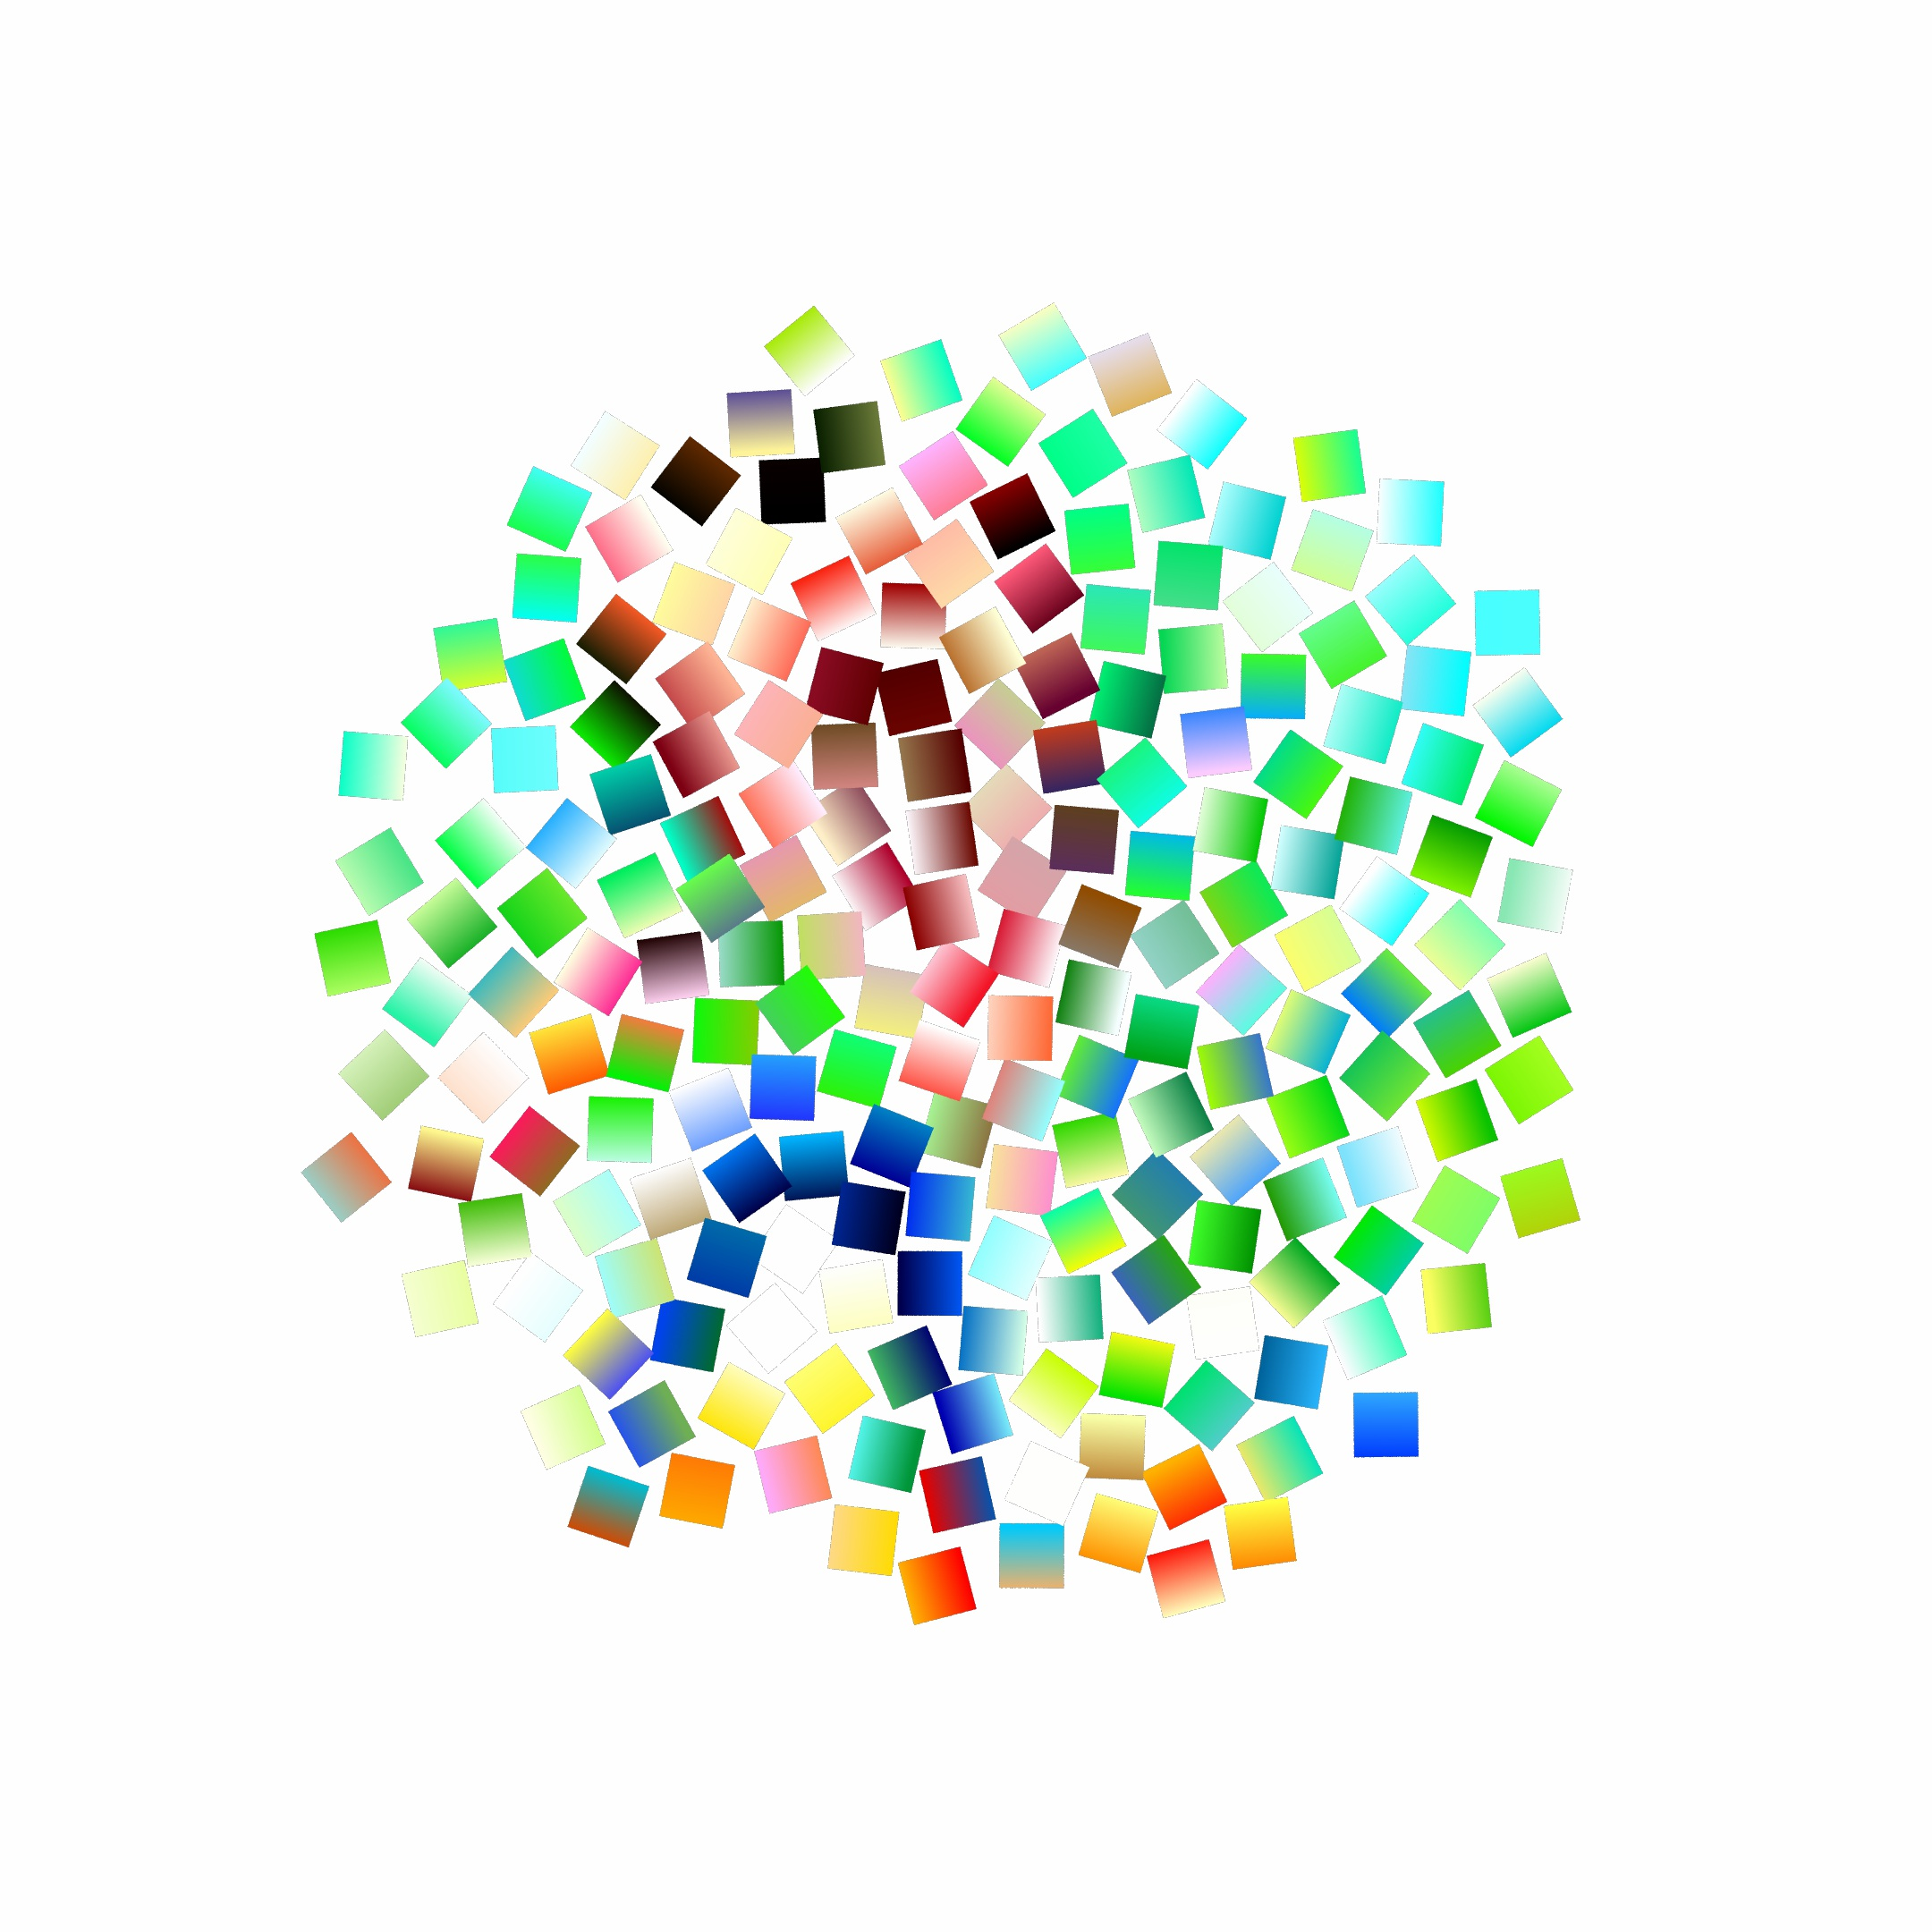

In [ ]:
shapes = []
shape_groups = []
for i in range(len(centers)):
  shapes.append(create_polygon_from_center_and_orientation(centers[i], angles[i], new_canvas_width,factor))
  shape_groups.append(pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),  fill_color = colors[i]))

scene_args = pydiffvg.RenderFunction.serialize_scene(\
        new_canvas_width, new_canvas_height, shapes, shape_groups)
render = pydiffvg.RenderFunction.apply
img = render(new_canvas_width, new_canvas_height, 2, 2, 0, None, *scene_args)
img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
img = img[:, :, :3]
img = img.unsqueeze(0)
img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
show_img(img.detach().cpu().numpy()[0])


In [ ]:
def save_images_main_colors(tile_photos_path, all_paths = False, image_format = 'jpg', tiles_path = "./tiles_color.json"):
  tiles_data = {}
  i = 0
  print("Saving images")
  if all_paths:
    for file in tile_photos_path:
      if i % 1000 == 0:
        print("Iteration {0}".format(i))
      
      tile = np.array(PIL.Image.open(file))
      left_color = tile[:,:15].mean(axis = 0).mean(axis = 0)/255
      right_color = tile[:][-16:-1].mean(axis = 0).mean(axis = 0)/255
      tiles_data[file] = [left_color.tolist(), right_color.tolist()]
      i+=1
    
    with open(tiles_path, 'w') as f:
      json.dump(tiles_data, f)
  else:

    for file in glob.glob(tile_photos_path + "/*.{0}".format(image_format)):
      #print(file)
      if i % 1000 == 0:
        print("Iteration {0}".format(i))
      
      tile = np.array(PIL.Image.open(file))
      left_color = tile[:,:15].mean(axis = 0).mean(axis = 0)/255
      right_color = tile[:][-16:-1].mean(axis = 0).mean(axis = 0)/255
      tiles_data[file] = [left_color.tolist(), right_color.tolist()]
      i+=1

    with open(tiles_path, 'w') as f:
      json.dump(tiles_data, f)

In [ ]:
path = "/content/drive/MyDrive/imagenet/train/"

subfolders = glob.glob(path + "/*")
images_paths = []
for sub in subfolders:
  #if len(images_paths) >= 1e3:
  #  break
  #images_paths += glob.glob(sub + "/*.JPEG")
  pass
print(len(images_paths))
#save_images_main_colors(images_paths,True, tiles_path = "./imagenet_colors.json")

0


In [ ]:
from scipy import spatial

tile_photos_path = "/content/drive/MyDrive/cats/"
tile_length = int(2*factor * new_canvas_width)
tile_size = (tile_length, tile_length)


# Get all tiles
#save_images_main_colors(tile_photos_path=tile_photos_path)
_ = """
tile_paths = []
for file in glob.glob(tile_photos_path + "/*.jpg"):
	  tile_paths.append(file)
 
# Import and resize all tiles
tiles = []
for i, path in enumerate(tile_paths):
    if i % 1000 == 0:
      print("Image {0}".format(i))
    tile = PIL.Image.open(path)
    tile = tile.resize(tile_size)
    tiles.append(tile)

#calculate left and right color
colors = []
for tile in tiles:
  tile = np.array(tile)
  left_color = tile[:][0].mean(axis=0)/255
  right_color = tile[:][-1].mean(axis=0)/255
  colors.append(np.array([left_color, right_color]))
colors = np.array(colors)"""

In [ ]:
with open("./tiles_color.json", 'r') as f:
  tiles_data = json.load(f)

In [ ]:
tiles_path, tiles_colors = list(tiles_data.keys()), list(tiles_data.values())
tiles_path_tmp, tiles_colors_tmp = [], []
for i in range(len(tiles_path)):
  tmp = np.array(tiles_colors[i])
  if len(tmp.shape) == 2:
    tiles_path_tmp.append(tiles_path[i])
    tiles_colors_tmp.append(tmp)
tiles_path = tiles_path_tmp
tiles_colors=tiles_colors_tmp
#tiles_colors = list(filter(lambda x: len(x.shape) == 2,[np.array(tile_color) for tile_color in tiles_colors]))

In [ ]:
tiles_colors = np.array(tiles_colors)

In [ ]:
tiles_colors.shape, len(tiles_path)

((4000, 2, 3), 4000)

In [ ]:
def find_closest_image_to_tile(tile_color, colors):
  left_color = tile_color.stop_colors[0].data.numpy()[:3] #discard alpha
  right_color = tile_color.stop_colors[1].data.numpy()[:3] #discard alpha
  color = np.vstack([left_color, right_color])
  distances = np.power(colors - color,2).mean(axis=2).sum(axis = 1)
  #print(distances.shape)
  closest_image = distances.argmin()
  #print(distances[closest_image])
  return closest_image

closest_tiles = np.zeros(300, dtype=np.uint32)
for i, shape_group in enumerate(shape_groups):
  tile_color = shape_group.fill_color
  closest_tiles[i] = find_closest_image_to_tile(tile_color, tiles_colors)

In [ ]:
normalised_angles=list(map(lambda x: x%(math.pi/2),angles))

In [ ]:
def get_upper_left_corner(points,factor=factor):
  for i in range(points.shape[0]):
    dists=torch.zeros(4)
    dists[i]=float('inf')
    for j in range(points.shape[0]):
      if i == j:
        continue
      dists[j]=torch.norm(points[i]-points[j])
    sorted_indices = torch.argsort(dists)
    adjacent1 = sorted_indices[0]
    adjacent2 = sorted_indices[1]
    e1=torch.tensor([1.0,0.0])
    e2=torch.tensor([0.0,1.0])
    v1=(adjacent1-points[i])
    v2=(adjacent2-points[i])
    
    if torch.dot(v1,e1)>=0 and (torch.dot(v2,e2)<=0):
      return points[i]



In [ ]:
centered_points=(shapes[0].points-shapes[0].points.mean(dim=0))
for j in range(centered_points.shape[0]):
      if centered_points[j][0]<=0 and  centered_points[j][1]>0:
        index_ul=j

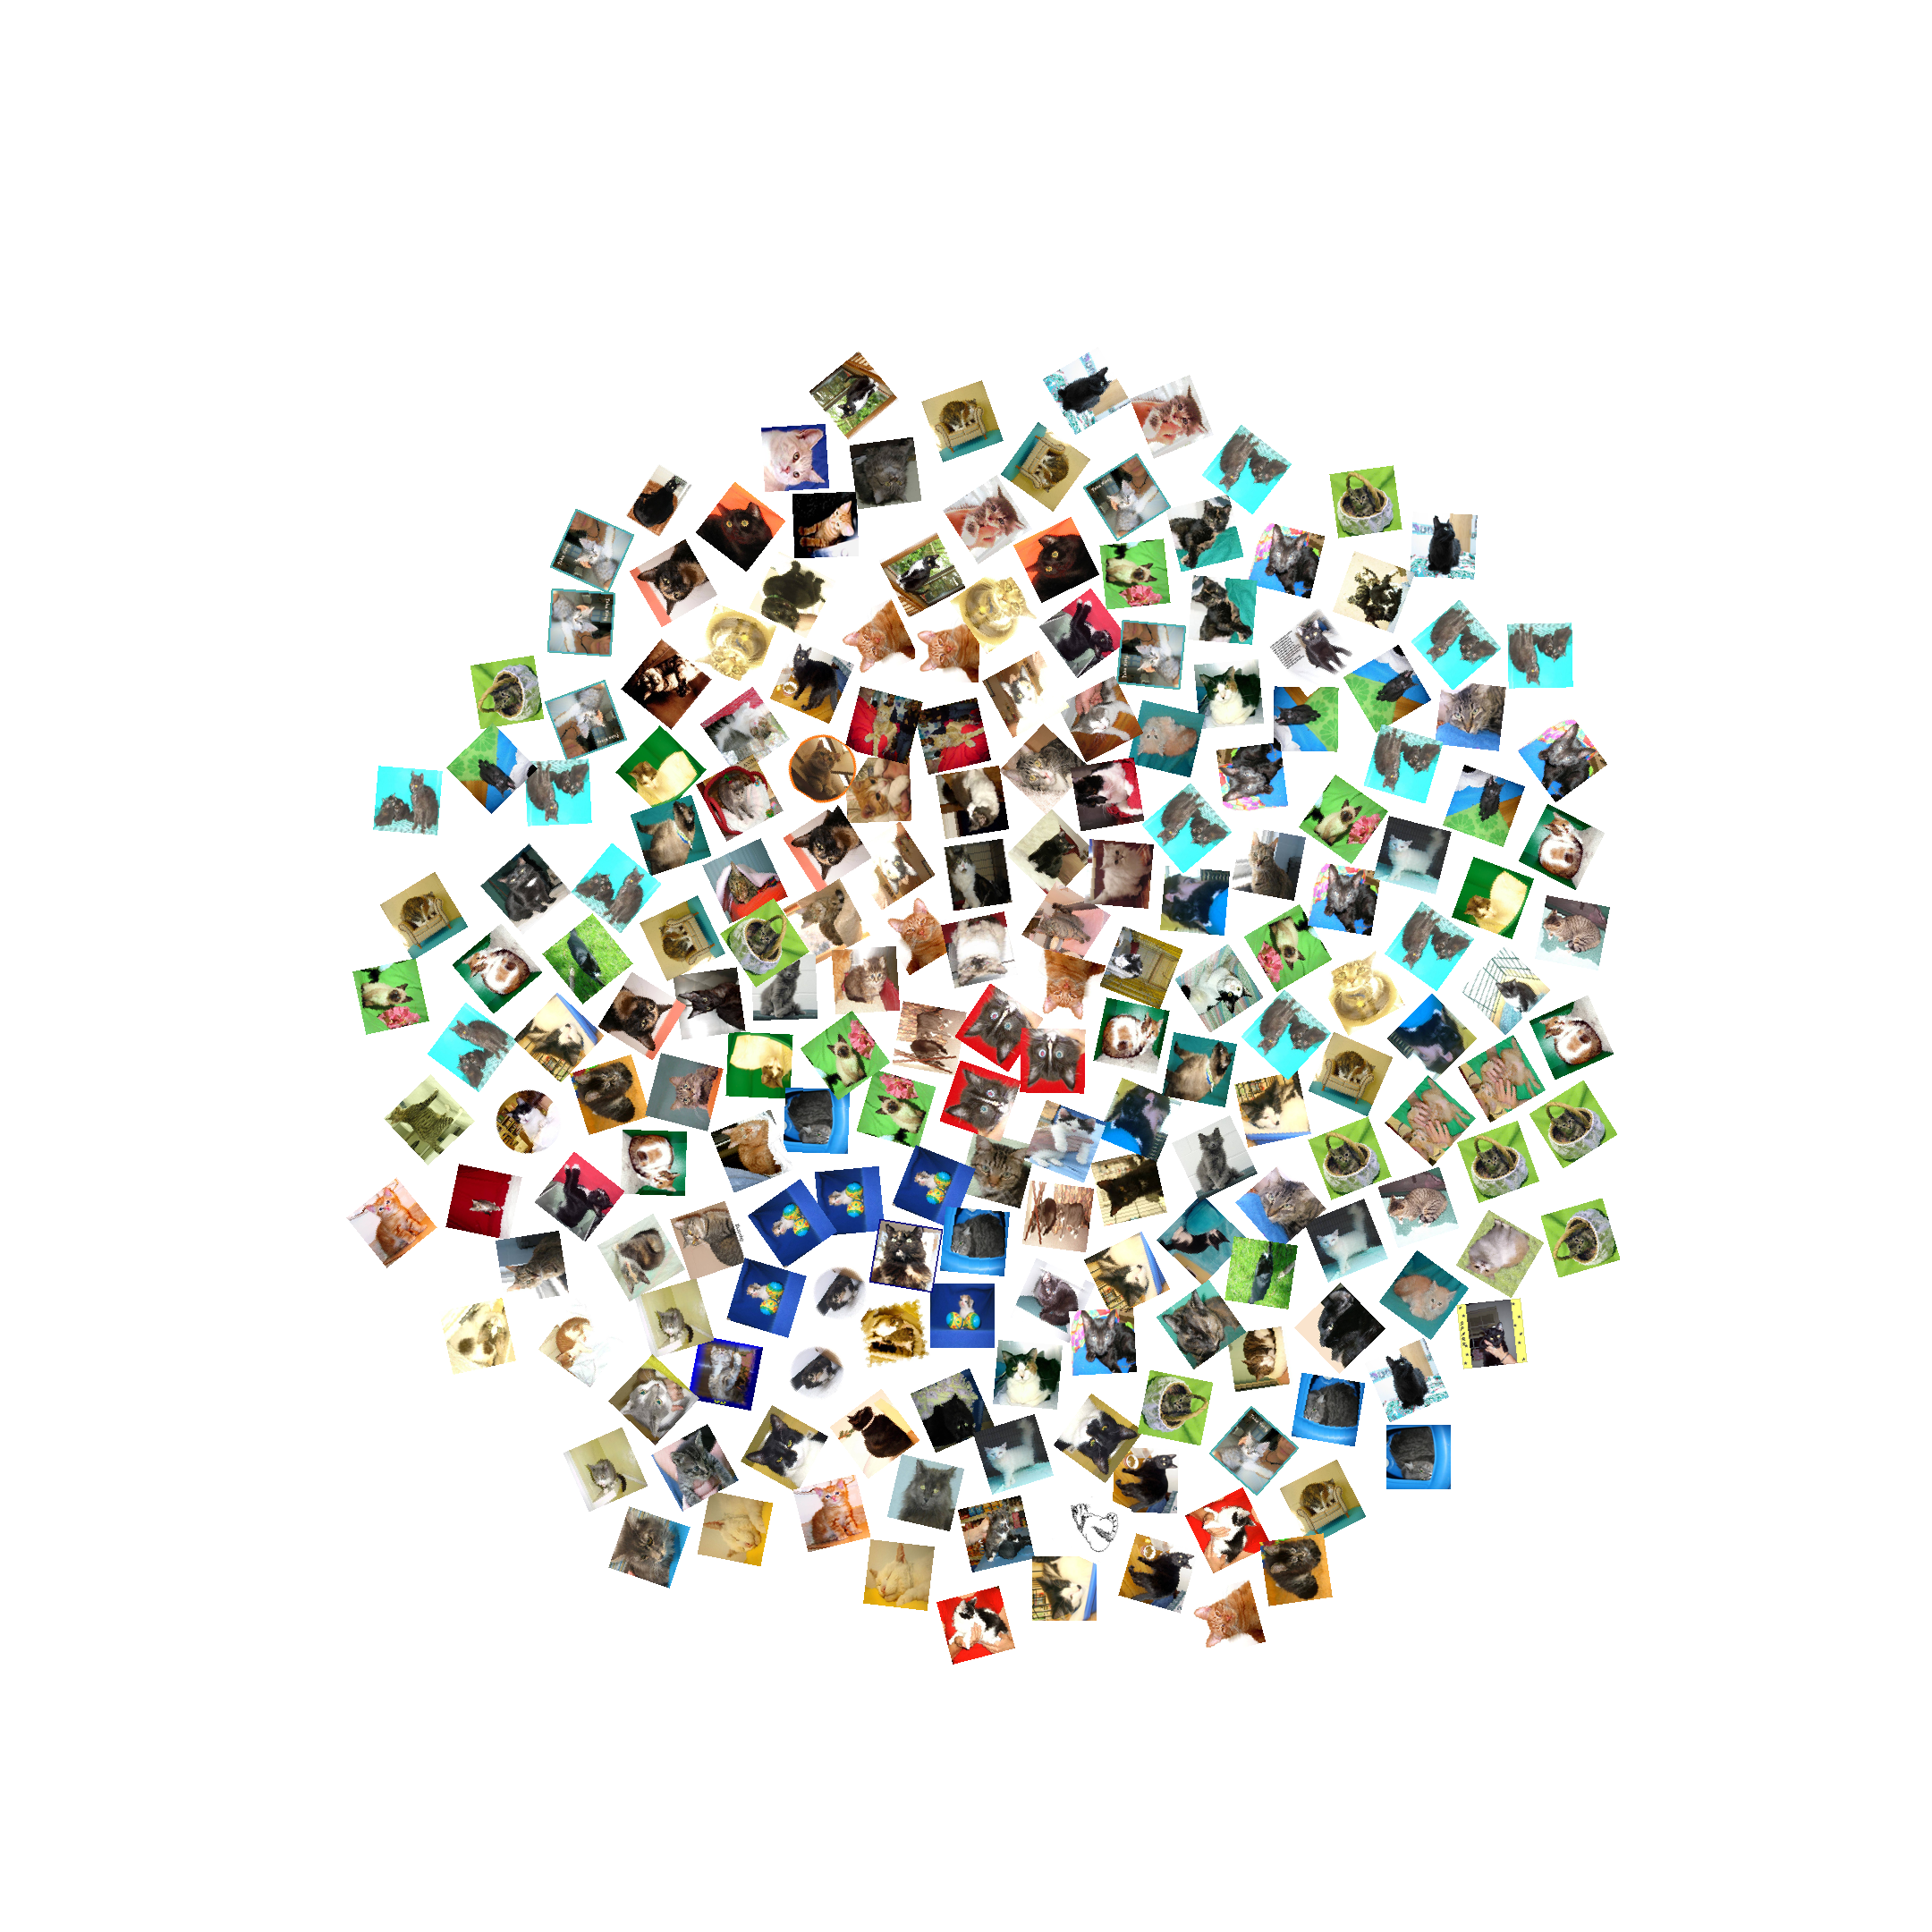

In [ ]:
# Create a white output image
output = PIL.Image.new('RGB', (new_canvas_width, new_canvas_height), (255,255,255))
normalised_angles=list(map(lambda x: x%(math.pi/2),angles))

# Draw tiles in the output image
for i, center in enumerate(centers):
    center = center[0] * new_canvas_width
    # Index of tile
    index = closest_tiles[i]
    # Draw tile

    path = tiles_path[index]
    tile = PIL.Image.open(path)
    tile = tile.resize(tile_size)
    # Convert from radians to degrees
    angle = angles[i] * 180 / np.pi
    # tile = tile.rotate(angle, expand=True)
    # # Left upper corner of the polygon
    #print(center)
    S=factor
    H=(torch.sin(angles[i])+torch.cos(angles[i]))*S
    x1, y1 = int(center[0]-H/2), int(center[1]-H/2)
    """
    centered_points=(shapes[i].points-shapes[i].points.mean(dim=0))
    for j in range(centered_points.shape[0]):
      if centered_points[j][0]<=0 and  -centered_points[j][1]>0:
        index_ul=j
        
    ul=shapes[i].points[index_ul]
    x1, y1 = int(ul[0]), int(ul[1])
    """
    # # Rigth lower corner
    #x2, y2 = int(shape.points.data.numpy()[0][0]), int(shape.points.data.numpy()[0][1])
    temp_poly= create_polygon_from_center_and_orientation(centers[i],angles[i],new_canvas_height,factor)
    if normalised_angles[i]<= math.pi/4:
      ul=temp_poly.points[0]
    else:
      ul=temp_poly.points[3]
  # x1, y1 = int(ul[0]), int(ul[1])

    


    # Mask is needed for rotation of the tile.
    mask =  PIL.Image.new('L', tile.size, 255)
    tile = tile.rotate(angle, expand=True)
    mask = mask.rotate(angle, expand=True)
    output.paste(tile, (x1, y1), mask)

    # output.paste(tile, (x1, y1))
    # output.paste(tile, (x1, y1, x2, y2))


output.show()

In [ ]:
#@title Video Renderer {vertical-output: true}

# Render a picture with each stroke.
with torch.no_grad():
    for i in range(args.num_polygons):
        print(i)
        scene_args = pydiffvg.RenderFunction.serialize_scene(\
            canvas_width, canvas_height, shapes[:i+1], shape_groups[:i+1])
        img = render(canvas_width, canvas_height, 2, 2, t, None, *scene_args)
        img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        pydiffvg.imwrite(img.cpu(), '/content/res/stroke_{}.png'.format(i), gamma=gamma)
print("ffmpeging")

# Convert the intermediate renderings to a video.
from subprocess import call
call(["ffmpeg", "-y", "-framerate", "60", "-i",
    "/content/res/iter_%d.png", "-vb", "20M",
    "/content/res/out.mp4"])

call(["ffmpeg", "-y", "-framerate", "60", "-i",
    "/content/res/stroke_%d.png", "-vb", "20M",
    "/content/res/out_strokes.mp4"])

call(["ffmpeg", "-y", "-i", "/content/res/out.mp4", "-filter_complex",
    "[0]trim=0:2[hold];[0][hold]concat[extended];[extended][0]overlay",
    "/content/res/out_longer.mp4"])

call(["ffmpeg", "-y", "-i", "/content/res/out_strokes.mp4", "-filter_complex",
    "[0]trim=0:2[hold];[0][hold]concat[extended];[extended][0]overlay",
    "/content/res/out_strokes_longer.mp4"])


display(mvp.ipython_display("/content/res/out_longer.mp4"))
display(mvp.ipython_display("/content/res/out_strokes_longer.mp4"))

In [ ]:
#@title Pixel Optimizer (Ignore) {vertical-output: true}

%cd /content/diffvg/apps/

prompt = "Underwater"
text_input = clip.tokenize(prompt).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_input)

import torch
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
import torchvision
import torchvision.transforms as transforms



class ImageBase(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.p = torch.nn.Parameter(torch.ones(224, 224, 3))
    def forward(self):
        return torch.nn.functional.sigmoid(self.p)

device = torch.device('cuda')
canvas_width, canvas_height = 224, 224

augment_trans = transforms.Compose([
    transforms.RandomPerspective(fill=1, p=1),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
])

ib = ImageBase().to(device)

t_img = imread('https://lh5.googleusercontent.com/mjvIYutjtOGEEU2cBYuFMvCrBCg4-MGh3DqCRlLqwn5I6VvdKdtwWvAYlndQbv-VUudPcecQ_TEGFjYaTuS_r0LNI83Sp8MlXJb6OarJ9mu-IkmKPlg9Gaw3gOjQvvgvuUB5ghJjlaE')
target = torch.from_numpy(t_img).to(torch.float32)
ib.p = target

# Optimize
optim = torch.optim.Adam(ib.parameters(), lr=0.01)
# Adam iterations.
for t in range(args.num_iter):
    optim.zero_grad()
    img = ib()
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW

    loss = 0
    for n in range(16):
        img_aug = augment_trans(img)
        image_features = model.encode_image(img_aug)
        loss -= torch.cosine_similarity(text_features, image_features, dim=1)
        # loss += torch.abs(torch.mean(1-img_aug)) * 0.1

    # Backpropagate the gradients.
    loss.backward()

    # Take a gradient descent step.
    optim.step()
    
    if t % 10 == 0:
        show_img(img.detach().cpu().numpy()[0])
        show_img(img_aug.detach().cpu().numpy()[0])
        print('render loss:', loss.item())
        print('iteration:', t)
        with torch.no_grad():
            im_norm = image_features / image_features.norm(dim=-1, keepdim=True)
            noun_norm = nouns_features / nouns_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * im_norm @ noun_norm.T).softmax(dim=-1)
            values, indices = similarity[0].topk(5)
            print("\nTop predictions:\n")
            for value, index in zip(values, indices):
                print(f"{nouns[index]:>16s}: {100 * value.item():.2f}%")

# Convert the intermediate renderings to a video.
from subprocess import call
call(["ffmpeg", "-framerate", "24", "-i",
    "results/painterly_rendering/iter_%d.png", "-vb", "20M",
    "results/painterly_rendering/out.mp4"])